# Model trainig

## Setup

In [1]:
import sys
import os

# Path to the files
module_path = os.path.abspath(r'H:\My Documents\CapstoneAI-FiberProbe-main') 
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
path_to_data = r'U:\Bubble Column\Data\2411_Xray alcohols\Fiber Probe\241108 - Water center of column' 
path_to_output = r'H:\My Documents\Capstone results'

# Libary imports
import pandas as pd
import torch
import numpy as np
import time
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import importlib
import models
importlib.reload(models)

# Function imports
from advanced_dataloading import process_folder
from advanced_preprocessing import frame_waves, valid_velo_data, save_second_scaler, random_noise, duplicate_and_augment_data, flatten_data_distribution, bin_data, calculate_duplication_factors
from models import load_scalers, load_models, LSTMModel, GRUModel, CNNModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}') # Check if the gpu is beining used

Using device: cuda


## Dataloading and preprocessing

In [3]:
#load the data
df = process_folder(path_to_data, path_to_output, files=[20,17,14,11,8,5,2], plot=False, labels=True,) 

Binlog data extracted
Processing run: 2024-11-08T161448
{'channelCoef1': 0.0, 'channelCoef2': 6.103701895199438e-05, 'acquisitionFrequency': 20833333.333333332, 'flowRate': 240, 'bin_file': '2024-11-08T161448.bin'}
836458000 datapoints extracted
LABELS: 640 bubble labels with VeloOut != -1 extracted.

Missing Labels:
L_idx: L253, ExitIdx: 327054128, VeloOut: 1.92765
L_idx: L384, ExitIdx: 490162316, VeloOut: 2.32511
EXTRACTED: 638 bubbles have VeloOut != -1 out of 3502 total bubbles.
            bubble_idx E_idx L_idx  VeloOut  \
0  0_2024-11-08T161448    E0    -1 -1.00000   
1  1_2024-11-08T161448    E1    -1 -1.00000   
2  2_2024-11-08T161448    E2    L0  1.46359   
3  3_2024-11-08T161448    E3    -1 -1.00000   
4  4_2024-11-08T161448    E4    -1 -1.00000   

                                          VoltageOut  FlowRate     Frequency  
0  [0.5804620385169983, 0.5878475308418274, 0.607...       240  2.083333e+07  
1  [0.6047548055648804, 0.6321604251861572, 0.632...       240  2.08333

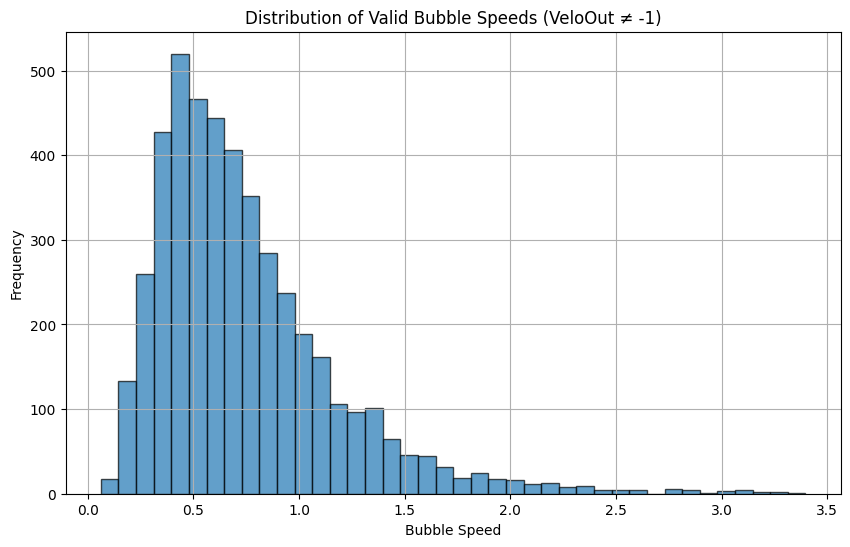

In [4]:
# Making a distribution plot to visualize the valid data
valid_speeds = df[df["VeloOut"] != -1]["VeloOut"]

plt.figure(figsize=(10, 6))
plt.hist(valid_speeds, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribution of Valid Bubble Speeds (VeloOut ≠ -1)")
plt.xlabel("Bubble Speed")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [5]:
# Split the data in train, validation and test set, scale them and save the scalers
feature_scaler, target_scaler, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled = save_second_scaler(df)

In [6]:
# Save the scalers so they can be used later
with open(path_to_output+'/scalers/feature_scaler2-20%3_600.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)

with open(path_to_output+'/scalers/target_scaler2-20%3_600.pkl', 'wb') as f:
    pickle.dump(target_scaler, f)

2
1.46359


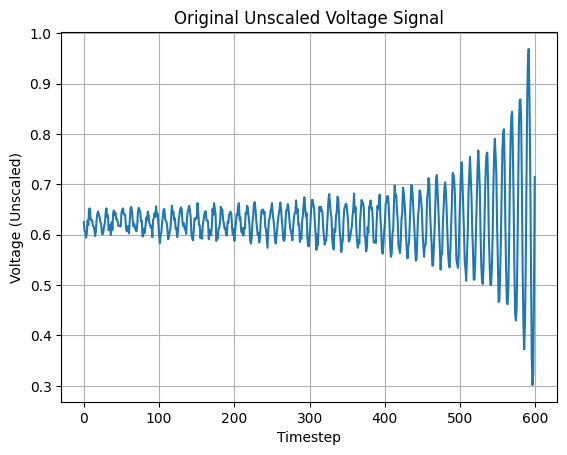

In [7]:
# Making an example plot of the sensor data that is used
i= 2 #index of the bubble that is showed

voltage_signal = df["VoltageOut"].iloc[i]
print(df['VeloOut'].iloc[i]) #print the according label
x = np.arange(len(voltage_signal))

# Plot
plt.plot(x, voltage_signal)
plt.title("Original Unscaled Voltage Signal")
plt.xlabel("Timestep")
plt.ylabel("Voltage (Unscaled)")
plt.grid(True)
plt.show()

In [8]:
# Adding random noise to the training data
chance = 0.3
X_train_scaled, y_train_scaled = random_noise(X_train_scaled, y_train_scaled, chance, random_seed = 0)

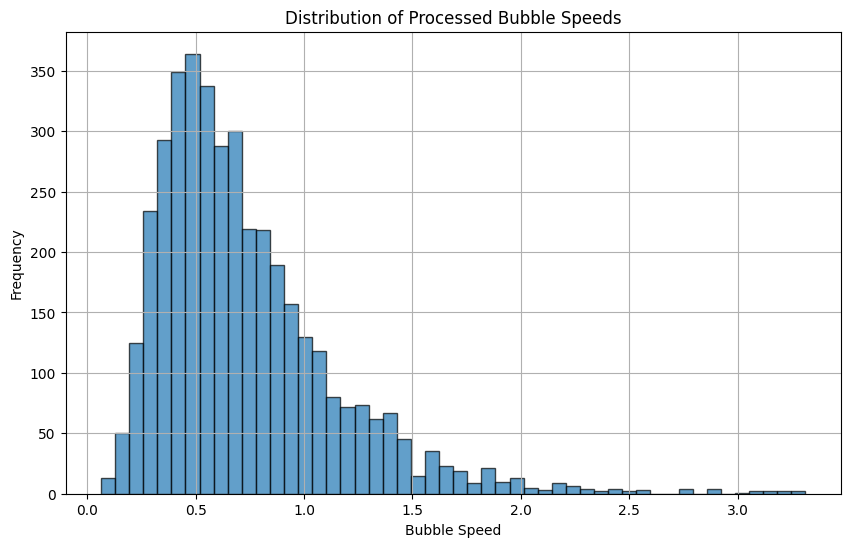

In [9]:
# Show the data distribution after adding noise
y_train_fig = target_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten() 
plt.figure(figsize=(10, 6))
plt.hist(y_train_fig, bins=50, edgecolor='black', alpha=0.7)
plt.title("Distribution of Processed Bubble Speeds")
plt.xlabel("Bubble Speed")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [10]:
# Show the size of x_train
X_train_scaled.shape

(3983, 600)

In [11]:
# Converting everything to torch tensors so the can be used for model training
X_train_tensor = torch.tensor(X_train_scaled[..., np.newaxis], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_scaled[..., np.newaxis], dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled[..., np.newaxis], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

## GRU model training

In [ ]:
# Input
input_size = 1 
hidden_size = 20
num_layers = 2
lr = 0.004
epochs = 7500
patience = 3000
# End of input

# Model setup
gru_model = GRUModel(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
gru_model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr = lr)

# Early stopping
patience = patience
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training loop
epochs = epochs
train_losses, val_losses = [], []

for epoch in range(epochs):
    gru_model.train()
    optimizer.zero_grad()
    y_pred_train = gru_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    gru_model.eval()
    with torch.no_grad():
        y_pred_val = gru_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = {k: v.clone() for k, v in gru_model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model
if best_model_state is not None:
    gru_model.load_state_dict(best_model_state)

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve with Early Stopping")
plt.legend()
plt.grid(True)
plt.show()

# Predict on validation set
gru_model.eval()
with torch.no_grad():
    y_pred_scaled = gru_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_gru = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_gru)
mae = mean_absolute_error(y_true, y_pred_gru)
r2 = r2_score(y_true, y_pred_gru)

print(f"RMSE: {rmse:.4f} cm/s")
print(f"MAE: {mae:.4f} cm/s")
print(f"R² Score: {r2:.4f}")

# Create parity plot
plt.figure()
plt.title('Parity plot trained GRU-model')
plt.scatter(y_true, y_pred_gru )
plt.xlabel('True Velocity')
plt.ylabel('Predicted Velocity')
plt.show()

## LSTM model training

In [ ]:
# Input
input_size = 1 
hidden_size = 30
num_layers = 2
lr = 0.0015
epochs = 40000
patience = 20000
# End of input

# Model setup
lstm_model = LSTMModel(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
lstm_model.to(device)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = lr)

# Early stopping setup
patience = patience
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training loop
epochs = epochs
train_losses, val_losses = [], []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    y_pred_train = lstm_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    lstm_model.eval()
    with torch.no_grad():
        y_pred_val = lstm_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = {k: v.clone() for k, v in lstm_model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 1000 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model weights
lstm_model.load_state_dict(best_model_state)

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("LSTM Training Curve (with Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


# Predict on validation set
lstm_model.eval()
with torch.no_grad():
    y_pred_scaled = lstm_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_lstm = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_lstm)
mae = mean_absolute_error(y_true, y_pred_lstm)
r2 = r2_score(y_true, y_pred_lstm)

print(f"RMSE: {rmse:.4f} cm/s")
print(f"MAE: {mae:.4f} cm/s")
print(f"R² Score: {r2:.4f}")

# Create parity plot
plt.figure()
plt.title('Parity plot trained LSTM-model')
plt.scatter(y_true, y_pred_lstm )
plt.xlabel('True Velocity')
plt.ylabel('Predicted Velocity')
plt.show()

Epoch 1/40000 - Train Loss: 0.9748 - Val Loss: 1.1608
Epoch 1000/40000 - Train Loss: 0.0195 - Val Loss: 0.0207


## CNN model training

Epoch 1/15000 - Train Loss: 0.9795 - Val Loss: 1.1591
Epoch 250/15000 - Train Loss: 0.0046 - Val Loss: 0.0051
Epoch 500/15000 - Train Loss: 0.0008 - Val Loss: 0.0045
Epoch 750/15000 - Train Loss: 0.0008 - Val Loss: 0.0040
Epoch 1000/15000 - Train Loss: 0.0013 - Val Loss: 0.0049
Epoch 1250/15000 - Train Loss: 0.0003 - Val Loss: 0.0042
Epoch 1500/15000 - Train Loss: 0.0003 - Val Loss: 0.0039
Epoch 1750/15000 - Train Loss: 0.0002 - Val Loss: 0.0035
Epoch 2000/15000 - Train Loss: 0.0312 - Val Loss: 0.0539
Epoch 2250/15000 - Train Loss: 0.0004 - Val Loss: 0.0037
Epoch 2500/15000 - Train Loss: 0.0002 - Val Loss: 0.0037
Epoch 2750/15000 - Train Loss: 0.0002 - Val Loss: 0.0041
Epoch 3000/15000 - Train Loss: 0.0001 - Val Loss: 0.0031
Epoch 3250/15000 - Train Loss: 0.0001 - Val Loss: 0.0028
Epoch 3500/15000 - Train Loss: 0.0001 - Val Loss: 0.0029
Epoch 3750/15000 - Train Loss: 0.0010 - Val Loss: 0.0035
Epoch 4000/15000 - Train Loss: 0.0000 - Val Loss: 0.0026
Epoch 4250/15000 - Train Loss: 0.0009

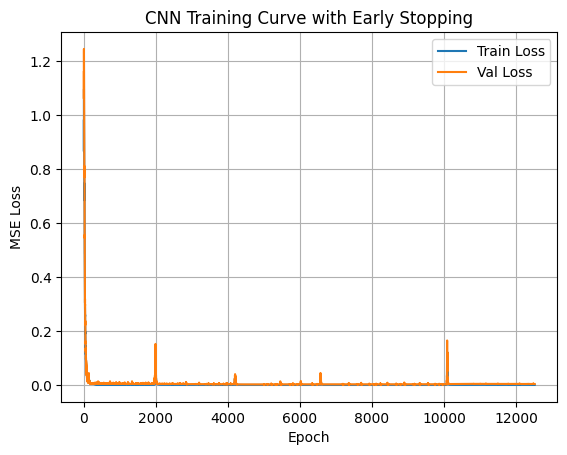

RMSE: 0.0003 cm/s
MAE: 0.0098 cm/s
R² Score: 0.9983


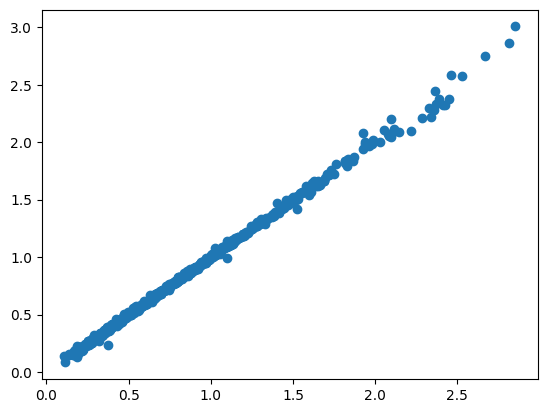

In [55]:
# Input
input_channels = 1 
hidden_units = 64
kernel_size = 15
num_layers = 5
input_length = 600
output_size = 1
lr = 0.001
epochs = 15000
patience = 7500
# End of input

# Model setup
cnn_model = CNNModel(input_channels = input_channels, hidden_units = hidden_units, kernel_size = kernel_size, num_layers = num_layers, input_length = input_length, output_size = output_size) 
cnn_model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = lr)

# Early stopping parameters
patience = patience
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training loop
epochs = epochs
train_losses, val_losses = [], []

for epoch in range(epochs):
    # Training
    cnn_model.train()
    optimizer.zero_grad()
    y_pred_train = cnn_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Validation
    cnn_model.eval()
    with torch.no_grad():
        y_pred_val = cnn_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = {k: v.clone() for k, v in cnn_model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Progress output
    if (epoch+1) % 250 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model
if best_model_state is not None:
    cnn_model.load_state_dict(best_model_state)

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("CNN Training Curve with Early Stopping")
plt.legend()
plt.grid(True)
plt.show()

# Predict on validation set
cnn_model.eval()
with torch.no_grad():
    y_pred_scaled = cnn_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_cnn = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_cnn)
mae = mean_absolute_error(y_true, y_pred_cnn)
r2 = r2_score(y_true, y_pred_cnn)

print(f"RMSE: {rmse:.4f} cm/s")
print(f"MAE: {mae:.4f} cm/s")
print(f"R² Score: {r2:.4f}")

plt.figure()
plt.scatter(y_pred_cnn,y_true)
plt.show()

## Model saving

In [57]:
# # Remove the '#'s to save the trained models
# torch.save(gru_model.state_dict(), path_to_output+"/models/gru28-5_2-20%3_is1_ns20_nl2_lr0.004_ep7500_r20.9982-")
# torch.save(lstm_model.state_dict(), path_to_output+"/models/lstm3-6_2-20%3_is1_ns18_nl2_lr0.005_ep50000_r20.9972-")
# torch.save(cnn_model.state_dict(), path_to_output+"/models/cnns-6_2-20%3_ic1_hu64_ks15_nl5_lr0.001_ep10000_r20.9983-")
